# Welcome to Phosphoproteomics workflow notebook

### This command is used to sync files from polly workspace

In [1]:
workspace_id = 7060
import subprocess as sb

getfilescmd = "polly files sync --workspace-id %(workspace_id)s -s polly://code -d ./uclacode"%locals()
sb.call(getfilescmd, shell = True)

1

### Importing necessary libraries

In [4]:
import shutil
import pickle
from collections import Counter
from re import findall
import sklearn
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from glob import glob
import uniprot
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import MultiComparison
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

## running Phosphoproteomics_C4-2_Actinium_48h_TTest


In [5]:
from uclacode.analysis import Phosphoproteomics

### Define required columns - 
1. This is a user entered field. Here user has to choose the applicable phosphoproteome column names such as sequence, accession, contaminant, quan colums and he/she needs to pass a list of untreated and pertubation columns. At last all the column named passed get added to a list named phospho_fields which will be used in further steps 

In [6]:
# Point the work directory towards the folder containing the data.
file_path = '/import/uclacode/'

# name of the metadata csv file
phospho_dataset = 'jc_QE_122218_C4-2_Actinium_48h_Phos-_PeptideGroups.csv'  

# columns to be used
phospho_sequence_column = 'Sequence'
phospho_accession_column = 'Protein Accessions'
phospho_modifications_column = 'Modifications (all possible sites)'
phospho_contaminant_column = 'Contaminant'
phospho_quan_column = 'Quan Info'

phospho_untreated_list =  ['Abundances (Scaled): F1: 126, Control, NT, 18632',
                           'Abundances (Scaled): F1: 127N, Sample, NT, 18633',
                           'Abundances (Scaled): F1: 127C, Sample, NT, 18636',
                           'Abundances (Scaled): F1: 128N, Sample, NT, 18639',
                           'Abundances (Scaled): F1: 128C, Sample, NT, 18640']

phospho_perturbation_list = ['Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
                             'Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
                             'Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
                             'Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
                             'Abundances (Scaled): F1: 131, Sample, RLT, 18575']

# Choose any other additional applicable phosphoproteome column names to feature in the output.
additional_columns = []

# Create a list that contains all of the desired columns within the data set.
phospho_fields = [phospho_sequence_column,
                  phospho_accession_column,
                  phospho_modifications_column,
                  phospho_contaminant_column,
                  phospho_quan_column] + additional_columns + \
                  phospho_untreated_list + phospho_perturbation_list

### Filtering step -
1. we are creating an object named "phospho" of Phosphoproteomics class (analysis.py)
2. Filtering the column values based on quan column, we don't want those quan columns where value is "NoQuanValues"

In [7]:
phospho = Phosphoproteomics(file_path, phospho_dataset, phospho_fields)
phospho = phospho.filter_column(phospho_quan_column, 'NoQuanValues')

Removing NoQuanValues values...
Removed 4410 NoQuanValues values


In [65]:
phospho.df.head(2)

Sequence      Protein Accessions            Modifications (all possible sites)  Contaminant Quan Info  Abundances (Scaled): F1: 126, Control, NT, 18632  Abundances (Scaled): F1: 127N, Sample, NT, 18633  Abundances (Scaled): F1: 127C, Sample, NT, 18636  Abundances (Scaled): F1: 128N, Sample, NT, 18639  Abundances (Scaled): F1: 128C, Sample, NT, 18640  Abundances (Scaled): F1: 129N, Sample, RLT, 18571  Abundances (Scaled): F1: 129C, Sample, RLT, 18572  Abundances (Scaled): F1: 130N, Sample, RLT, 18573  Abundances (Scaled): F1: 130C, Sample, RLT, 18574  Abundances (Scaled): F1: 131, Sample, RLT, 18575
0  AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...        O60341-2; O60341  1xDeamidated [N27; Q34]; 1xTMT6plex [N-Term]        False       NaN                                              97.2                                              99.3                                              99.5                                              96.3                                              96.3                                               99.1                                               86.1                                              124.8                                               86.8                                             114.7
1                                    IDQYQGADAVGLEEK  K7ER96; K7EML9; O43396         1xTMT6plex [K15]; 1xTMT6plex [N-Term]        False       NaN                                              97.4                                              84.3                                              85.9                                              77.5                                              83.1                                              102.1                                              115.2                                              132.2                                              108.5                                             113.7

### Creating list of fasta files which will get used in processing step

In [8]:
fasta_files = glob("/import/uclacode/fastafilles/*.fasta")
fasta_files

['/import/uclacode/fastafilles/uniprot-proteome%3AUP000005640.fasta',
 '/import/uclacode/fastafilles/uniprot-proteome%3AUP000000589.fasta']

### Processing step - 
This step requires 5 inputs - contaminant column, sequence column, accession column, modifications column and list containing full path to fasta files.
1. It starts by filtering out the contaminant column from phospho dataframe. 
2. Next we create an empty dictionary and add key-value pairs of sequences, accession ids, Modifications and find out their ranges using findall_ranges function. 
3. Create a list of lists that contains the individual modifications that are carried out on each observation.
4. Determine the key features that appear in the modifications column using findall_unique_mod_types function. 
5. Create a dictionary that breaks the modifcations column and creates individual lists for each key feature of the modifications using mods_dict_updater function.
6. Create lists for the LHS and RHS of the range for each entry of the sequence list using the UniProt fasta file using findall_uniprot_ranges function.
7. Get gene names, protein names and protein entry names using findall_uniprot_protein_names function with input as accessions and fasta files list created previously and save them to dictionary created above.
8. Create a dictionary that breaks the modifications column and creates individual lists for each key feature of the modifications that is statistically significant using sig_mods_dict_updater function. 
9. Create a dictionary that contains individual lists for each key feature of the modifications that is statistically significant. The lists within this dictionary will then eventually be brought together to create the Doug Annotations column.
10. Calculate doug annotations using add_doug_annotations function with dict, mods_dict and significant mods_dict and append then to the dictionary created above.
11. Determine centralised sequences using uniprot_centralised_sequence function that takes accession ids, significant positions found out using significant mod_dict modified and append then to the dictionary. this step is performed for all the mod names (output from doug_annotation step) that we have. 
12. return all the results formed in the function as self.


In [9]:
phospho = phospho.process_data(phospho_contaminant_column, 
                               phospho_sequence_column,
                               phospho_accession_column,
                               phospho_modifications_column,
                               fasta_files)

Class one Phospho peptide percentage found: 0.9195608506984375
Class one Phospho peptide count: 59971
Phospho sum: 19652
Phospho count saved to: Phospho_percentage_count.csv


In [68]:
phospho.df.head(3)

Sequence                                 Protein Accessions                 Modifications (all possible sites)  Contaminant Quan Info  Abundances (Scaled): F1: 126, Control, NT, 18632  Abundances (Scaled): F1: 127N, Sample, NT, 18633  Abundances (Scaled): F1: 127C, Sample, NT, 18636  Abundances (Scaled): F1: 128N, Sample, NT, 18639  Abundances (Scaled): F1: 128C, Sample, NT, 18640  Abundances (Scaled): F1: 129N, Sample, RLT, 18571  Abundances (Scaled): F1: 129C, Sample, RLT, 18572  Abundances (Scaled): F1: 130N, Sample, RLT, 18573  Abundances (Scaled): F1: 130C, Sample, RLT, 18574  Abundances (Scaled): F1: 131, Sample, RLT, 18575
0  AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...                                   O60341-2; O60341       1xDeamidated [N27; Q34]; 1xTMT6plex [N-Term]        False       NaN                                              97.2                                              99.3                                              99.5                                              96.3                                              96.3                                               99.1                                               86.1                                              124.8                                               86.8                                             114.7
1                                    IDQYQGADAVGLEEK                             K7ER96; K7EML9; O43396              1xTMT6plex [K15]; 1xTMT6plex [N-Term]        False       NaN                                              97.4                                              84.3                                              85.9                                              77.5                                              83.1                                              102.1                                              115.2                                              132.2                                              108.5                                             113.7
2                          STSAPQMSPGSSDNQSSSPQPAQQK  Q14157-1; F8W726; Q14157-5; Q14157-4; Q14157; ...  1xDeamidated [Q6; N14; Q15; Q20; Q23; Q24]; 1x...        False       NaN                                              90.9                                             100.1                                              97.9                                             105.3                                              99.8                                              116.1                                              101.3                                              117.1                                               98.8                                              72.7

In [76]:
phospho.dict.keys()

dict_keys(['Protein Accessions', 'Modifications (all possible sites)', 'Protein Accession Ranges', 'Sequence', 'Protein Name', 'Protein Entry Name', 'Gene Name', 'Phospho Site', 'Phospho Annotations', 'Phospho Centralised Sequence', 'Abundances (Scaled): F1: 126, Control, NT, 18632', 'Abundances (Scaled): F1: 127N, Sample, NT, 18633', 'Abundances (Scaled): F1: 127C, Sample, NT, 18636', 'Abundances (Scaled): F1: 128N, Sample, NT, 18639', 'Abundances (Scaled): F1: 128C, Sample, NT, 18640', 'Abundances (Scaled): F1: 129N, Sample, RLT, 18571', 'Abundances (Scaled): F1: 129C, Sample, RLT, 18572', 'Abundances (Scaled): F1: 130N, Sample, RLT, 18573', 'Abundances (Scaled): F1: 130C, Sample, RLT, 18574', 'Abundances (Scaled): F1: 131, Sample, RLT, 18575'])

In [10]:
for file in glob("./*percentage_count.csv"):
    shutil.move(file,"./Phosphoproteomics_Output")

# Read Proteomics

### Defining input csv file name along with  required column names 

In [10]:
proteomics_dataset = '/import/uclacode/jc_QE_122218_C4-2_Actinium_48h_Global-Unfiltered_Proteins.csv'  

# Choose the applicable proteomics column names.
proteomics_accession_column = 'Accession'
proteomics_contaminant_column = 'Contaminant'
proteomics_id_column = 'Protein Group IDs'

proteomics_untreated_list = ['Abundances (Scaled): F1: 126, Control, NT, 18632',
                           'Abundances (Scaled): F1: 127N, Sample, NT, 18633',
                           'Abundances (Scaled): F1: 127C, Sample, NT, 18636',
                           'Abundances (Scaled): F1: 128N, Sample, NT, 18639',
                           'Abundances (Scaled): F1: 128C, Sample, NT, 18640']

proteomics_perturbation_list = ['Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
                             'Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
                             'Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
                             'Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
                             'Abundances (Scaled): F1: 131, Sample, RLT, 18575']

proteomics_fields = [proteomics_accession_column,
                     proteomics_contaminant_column, proteomics_id_column] + proteomics_untreated_list + proteomics_perturbation_list

# this function will read the proteomics datasets csv file and save it to phospho object itself 
phospho = phospho.read_proteomics(proteomics_dataset, proteomics_fields)

In [11]:
phospho.df.head(3)

Sequence                                 Protein Accessions                 Modifications (all possible sites)  Contaminant Quan Info  Abundances (Scaled): F1: 126, Control, NT, 18632  Abundances (Scaled): F1: 127N, Sample, NT, 18633  Abundances (Scaled): F1: 127C, Sample, NT, 18636  Abundances (Scaled): F1: 128N, Sample, NT, 18639  Abundances (Scaled): F1: 128C, Sample, NT, 18640  Abundances (Scaled): F1: 129N, Sample, RLT, 18571  Abundances (Scaled): F1: 129C, Sample, RLT, 18572  Abundances (Scaled): F1: 130N, Sample, RLT, 18573  Abundances (Scaled): F1: 130C, Sample, RLT, 18574  Abundances (Scaled): F1: 131, Sample, RLT, 18575
0  AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...                                   O60341-2; O60341       1xDeamidated [N27; Q34]; 1xTMT6plex [N-Term]        False       NaN                                              97.2                                              99.3                                              99.5                                              96.3                                              96.3                                               99.1                                               86.1                                              124.8                                               86.8                                             114.7
1                                    IDQYQGADAVGLEEK                             K7ER96; K7EML9; O43396              1xTMT6plex [K15]; 1xTMT6plex [N-Term]        False       NaN                                              97.4                                              84.3                                              85.9                                              77.5                                              83.1                                              102.1                                              115.2                                              132.2                                              108.5                                             113.7
2                          STSAPQMSPGSSDNQSSSPQPAQQK  Q14157-1; F8W726; Q14157-5; Q14157-4; Q14157; ...  1xDeamidated [Q6; N14; Q15; Q20; Q23; Q24]; 1x...        False       NaN                                              90.9                                             100.1                                              97.9                                             105.3                                              99.8                                              116.1                                              101.3                                              117.1                                               98.8                                              72.7

# calculating fold change
1. This function requires 4 inputs accession ids, proteomics ids, untreated columns and perturbation columns list.
2. code starts by calculating the length of untreated list and perturbation list and then fold change is calculated by taking the mean of pertubation column values / mean of untreated column values. 
3. next we calculate the id_fold_change by zipping accession ids with their respective fold change values calculated above.
4. proteomics_fold_change_dict is created by converting id_fold_change to a dictonary.
5. proteomics_accesion_id_dict is created by using values of accession ids and proteomics ids.
6. return all the results formed in the function as self.

In [12]:
phospho = phospho.proteomics_fold_change(proteomics_accession_column, proteomics_id_column, proteomics_untreated_list, proteomics_perturbation_list)

# protein normalization
1. it takes untreated columns and pertubation columns as input. It starts with creating a new list abundances_scaled which contains all elements of both input lists.
2. Next we append the columns from phospho dataframe using the column names present in abundance list into the dictionary we created in processing step. 
3. Calculate mean of untreated and pertubation column values and save them in dataframe. Next calculate Phosphoproteomics Fold Change by dividing Pertubation mean with untreated mean values. 
4. Similarly calcuate Proteomics fold change using proteomics untreated and pertubation list. 
5. Next we calculate the Average Proteomics Fold Change by taking average of Proteomics Fold Change values.
6. Next Normalized Fold Change is calculated by dividing Proteomics Fold Change by Average Proteomics Fold Change.
7. These normalized values are added into the dataframe and we return all the resultant values as self. 

In [13]:
phospho = phospho.normalize_data(phospho_untreated_list, phospho_perturbation_list)

In [14]:
phospho.df.head(3)

Protein Accessions                 Modifications (all possible sites)                           Protein Accession Ranges                                           Sequence                                       Protein Name                                 Protein Entry Name                                         Gene Name                                      Phospho Site                                Phospho Annotations                       Phospho Centralised Sequence Abundances (Scaled): F1: 126, Control, NT, 18632 Abundances (Scaled): F1: 127N, Sample, NT, 18633 Abundances (Scaled): F1: 127C, Sample, NT, 18636 Abundances (Scaled): F1: 128N, Sample, NT, 18639 Abundances (Scaled): F1: 128C, Sample, NT, 18640 Abundances (Scaled): F1: 129N, Sample, RLT, 18571 Abundances (Scaled): F1: 129C, Sample, RLT, 18572 Abundances (Scaled): F1: 130N, Sample, RLT, 18573 Abundances (Scaled): F1: 130C, Sample, RLT, 18574  \
0                                 [O60341-2, O60341]       1xDeamidated [N27; Q34]; 1xTMT6plex [N-Term]                                 [[7, 58], [7, 58]]  AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...  [Isoform 2 of Lysine-specific histone demethyl...                         [KDM1A_HUMAN, KDM1A_HUMAN]                                    [KDM1A, KDM1A]                                              None                                             [None]                                             [None]                                             97.2                                             99.3                                             99.5                                             96.3                                             96.3                                              99.1                                              86.1                                             124.8                                              86.8   
1                           [K7ER96, K7EML9, O43396]              1xTMT6plex [K15]; 1xTMT6plex [N-Term]                    [[84, 98], [75, 89], [88, 102]]                                    IDQYQGADAVGLEEK  [Thioredoxin-like protein 1 (Fragment), Thiore...          [K7ER96_HUMAN, K7EML9_HUMAN, TXNL1_HUMAN]                             [TXNL1, TXNL1, TXNL1]                                              None                                             [None]                                             [None]                                             97.4                                             84.3                                             85.9                                             77.5                                             83.1                                             102.1                                             115.2                                             132.2                                             108.5   
2  [Q14157-1, F8W726, Q14157-5, Q14157-4, Q14157,...  1xDeamidated [Q6; N14; Q15; Q20; Q23; Q24]; 1x...  [[460, 484], [471, 495], [460, 484], [453, 477...                          STSAPQMSPGSSDNQSSSPQPAQQK  [Isoform 2 of Ubiquitin-associated protein 2-l...  [UBP2L_HUMAN, F8W726_HUMAN, UBP2L_HUMAN, UBP2L...  [UBAP2L, UBAP2L, UBAP2L, UBAP2L, UBAP2L, UBAP2L]  [[S477], [S488], [S477], [S470], [S477], [S477]]  [[Q14157-1 1xPhospho S477(98.9)], [F8W726 1xPh...  [[DNQSSsPQPAQ], [DNQSSsPQPAQ], [DNQSSsPQPAQ], ...                                             90.9                                            100.1                                             97.9                                            105.3                                             99.8                                             116.1                                             101.3                                             117.1                                              98.8   

  Abundances (Scaled): F1: 131, Sample, RLT, 18575  Untreated Mean  Perturbation Mean  Phosphoproteomics Fold Change                             Proteomics Fold Change  Average Proteomics Fold Change  

In [15]:
phospho.df.to_csv("PhosphoProteomics_till_Norm.csv",index=None)

# Filter Modifications
1. This used filter_mods function that takes as input mod_list it basically checkks the doug annotations results and check if any of them has name mentioned in mod_list if yes then it will filter that out and return dataframe 

In [77]:
phospho.df.shape

(65217, 57)

In [78]:
mod_list = ['Phospho']
phospho = phospho.filter_mods(mod_list)
phospho.df.shape

(59971, 57)

In [79]:
phospho.df.head(2)

Protein Accessions                 Modifications (all possible sites)                           Protein Accession Ranges                                    Sequence                                       Protein Name                                 Protein Entry Name                                         Gene Name                                      Phospho Site                                Phospho Annotations                       Phospho Centralised Sequence Abundances (Scaled): F1: 126, Control, NT, 18632 Abundances (Scaled): F1: 127N, Sample, NT, 18633 Abundances (Scaled): F1: 127C, Sample, NT, 18636 Abundances (Scaled): F1: 128N, Sample, NT, 18639 Abundances (Scaled): F1: 128C, Sample, NT, 18640 Abundances (Scaled): F1: 129N, Sample, RLT, 18571 Abundances (Scaled): F1: 129C, Sample, RLT, 18572 Abundances (Scaled): F1: 130N, Sample, RLT, 18573 Abundances (Scaled): F1: 130C, Sample, RLT, 18574 Abundances (Scaled): F1: 131, Sample, RLT, 18575  \
2  [Q14157-1, F8W726, Q14157-5, Q14157-4, Q14157,...  1xDeamidated [Q6; N14; Q15; Q20; Q23; Q24]; 1x...  [[460, 484], [471, 495], [460, 484], [453, 477...                   STSAPQMSPGSSDNQSSSPQPAQQK  [Isoform 2 of Ubiquitin-associated protein 2-l...  [UBP2L_HUMAN, F8W726_HUMAN, UBP2L_HUMAN, UBP2L...  [UBAP2L, UBAP2L, UBAP2L, UBAP2L, UBAP2L, UBAP2L]  [[S477], [S488], [S477], [S470], [S477], [S477]]  [[Q14157-1 1xPhospho S477(98.9)], [F8W726 1xPh...  [[DNQSSsPQPAQ], [DNQSSsPQPAQ], [DNQSSsPQPAQ], ...                                             90.9                                            100.1                                             97.9                                            105.3                                             99.8                                             116.1                                             101.3                                             117.1                                              98.8                                             72.7   
3                                           [Q6P2E9]  1xCarbamidomethyl [C33]; 1xDeamidated [N20; N2...                                         [[22, 63]]  LDRPAGGPSAESPRPSSAYNGDLNGLLVPDPLCSGDSTSANK             [Enhancer of mRNA-decapping protein 4]                                       [EDC4_HUMAN]                                            [EDC4]  [[S477], [S488], [S477], [S470], [S477], [S477]]  [[Q14157-1 1xPhospho S477(98.9)], [F8W726 1xPh...                                             [None]                                            125.2                                               67                                             84.5                                               85                                             91.7                                              83.9                                             105.2                                             130.5                                             133.3                                             93.8   

   Untreated Mean  Perturbation Mean  Phosphoproteomics Fold Change                             Proteomics Fold Change  Average Proteomics Fold Change  Normalized Fold Change Proteomics Abundances (Scaled): F1: 126, Control, NT, 18632  Average Proteomics Abundances (Scaled): F1: 126, Control, NT, 18632 Proteomics Abundances (Scaled): F1: 127N, Sample, NT, 18633  Average Proteomics Abundances (Scaled): F1: 127N, Sample, NT, 18633 Proteomics Abundances (Scaled): F1: 127C, Sample, NT, 18636  Average Proteomics Abundances (Scaled): F1: 127C, Sample, NT, 18636 Proteomics Abundances (Scaled): F1: 128N, Sample, NT, 18639  Average Proteomics Abundances (Scaled): F1: 128N, Sample, NT, 18639 Proteomics Abundances (Scaled): F1: 128C, Sample, NT, 18640  Average Proteomics Abundances (Scaled): F1: 128C, Sample, NT, 18640 Proteomics Abundances (Scaled): F1: 129N, Sample, RLT, 18571  Average Proteomics Abundances (Scaled): F1: 129N, Sample, RLT, 18571  \
2           98.80             101.20                       1.024291  [0.8213440

# T Test Analysis
**Params required -**
1. treatment_list: A list of key words that define each experiment being carried out i.e.  ['KRASi', 'FGFRi', 'Combo'].
2. phospho_untreated_list: A list of column names that contain the untreated results.
3. phospho_perturbation_list: A list of column names that contain all* the treated results. All the columns that contain the key words found in the treatment_list variable.
4. fdr_percentage: A float i.e. 0.05. (The false discovery rate (FDR) is a statistical approach used in multiple hypothesis testing to correct for multiple comparisons. It is typically used in high-throughput experiments in order to correct for random events that falsely appear significant.)
5. returns: A DataFrame containing the statistical results from all of the T-Tests carried out.

**T-Test is performed on normalized untreated and perturbation column values created above.**

1. independent two sample t-test is performed using scipy.stats module of python. it takes column values from normalized_untreated_list and normalized_perturbation_list in a loop and append the resultant p values in normalized_p_value list and resultant t-statistic value into normalized_t_statistic list.
2. It also appends division result of mean of normalized_perturbation_list and mean of normalized_untreated_list into normalized_fold_change list. 
3. We calcuate log normalized fold change using normalized_fold_change and append it to normalized_log_2_fold_change list.
4. Next all four calculated lists - normalized_t_statistic,normalized_p_value, normalized_fold_change and normalized_log_2_fold_change are added as columns to dataframe. 
5. Next we sort the columns based on P-values and create a rank column using range of log2(Fold Change) column and calculate total proteins using sum of Normalized proteins columns. 
6. FDR values are calcuated by - (df['Rank'] / total_proteins) * fdr_percentage_value
7. significant and non-significant proteins are calculated based on comparison of p-value with FDR calculations, if p-value is less than FDR than significant and vice versa.
7. at last we display the number of significant proteins with other statistics like total false positive hits etc. 


In [17]:
#Specify protein normalized columns to use in TTest:
untreated_list = ['Protein Normalized Abundances (Scaled): F1: 126, Control, NT, 18632',
                           'Protein Normalized Abundances (Scaled): F1: 127N, Sample, NT, 18633',
                           'Protein Normalized Abundances (Scaled): F1: 127C, Sample, NT, 18636',
                           'Protein Normalized Abundances (Scaled): F1: 128N, Sample, NT, 18639',
                           'Protein Normalized Abundances (Scaled): F1: 128C, Sample, NT, 18640']

perturbation_list = ['Protein Normalized Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
                             'Protein Normalized Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
                             'Protein Normalized Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
                             'Protein Normalized Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
                             'Protein Normalized Abundances (Scaled): F1: 131, Sample, RLT, 18575']

#Select false discovery rate for TTest
fdr_value = 0.05

#Specify treatment groups
treatments = ['RLT']

#Run TTest
phospho_t_test = phospho.t_test_analysis(fdr_percentage = fdr_value, 
                                         phospho_untreated_list = untreated_list,
                                         phospho_perturbation_list = perturbation_list,
                                         treatment_list = treatments)

t_test_output = 'Phosphoproteomics_Output/' + phospho_dataset.replace('.csv','') + ' (Output FDR value ' + str(fdr_value) + ') (TTest).csv'  # In .csv format!
phospho_t_test.to_csv(t_test_output)

Treatment: RLT
Number of significant proteins: 3868
0.20698881575426767% of the identified at the set FDR
193.4 total false positive hits




# One-way Anova
1. One way Anova is done using scipy.stats module in python with function f_oneway. 
2. It requires as input untreated and perturbation column names along with fdr value and experiment type. 
3. It starts by making a list named columns which has all the values of untreated and perturbation lists. 
4. We make sure that all null values in the dataframe belonging to these specific columns are removed. 
5. f_oneway anova function is used and dataframe, columns and experiment types are given as input and it outputs F-statistics and P-value which are saved as columns into the dataframe followed by sorting the dataframe based on p-value. 
6. next we make a rank column using the numpy's arange function on length of dataframe.
7. total proteins are calculated by measuring the count of entries in P-value column where value is not none or missing. 
8. FDR calculation is done based on this formula - fdr_percentage * (df['Rank'] / total_proteins)
9. Next we create a fdr list having only those entries where FDR calculated value in more than p-value. 
10. at last we calculate the significant proteins by taking sum of entries of FDR column and display the results similar to t-test. 


In [18]:
# Specify protein normalized columns to use in one-way ANOVA:
untreated_list = ['Protein Normalized Abundances (Scaled): F1: 126, Control, NT, 18632',
                           'Protein Normalized Abundances (Scaled): F1: 127N, Sample, NT, 18633',
                           'Protein Normalized Abundances (Scaled): F1: 127C, Sample, NT, 18636',
                           'Protein Normalized Abundances (Scaled): F1: 128N, Sample, NT, 18639',
                           'Protein Normalized Abundances (Scaled): F1: 128C, Sample, NT, 18640']

perturbation_list = ['Protein Normalized Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
                             'Protein Normalized Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
                             'Protein Normalized Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
                             'Protein Normalized Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
                             'Protein Normalized Abundances (Scaled): F1: 131, Sample, RLT, 18575']


#Give catch word to create separate experimental groups:
experiment_types = ['NT', 'RLT']

# Choose an FDR percentage for the analysis.
fdr_value = 0.01

# Choose an output file name and desired file path.
anova_output_file = 'Phosphoproteomics_Output/' + phospho_dataset.replace('.csv','') + ' (Output FDR value ' + str(fdr_value) + ') (ANOVA).csv'  # In .csv format!

In [19]:
phospho.df.columns

Index(['Protein Accessions', 'Modifications (all possible sites)',
       'Protein Accession Ranges', 'Sequence', 'Protein Name',
       'Protein Entry Name', 'Gene Name', 'Phospho Site',
       'Phospho Annotations', 'Phospho Centralised Sequence',
       'Abundances (Scaled): F1: 126, Control, NT, 18632',
       'Abundances (Scaled): F1: 127N, Sample, NT, 18633',
       'Abundances (Scaled): F1: 127C, Sample, NT, 18636',
       'Abundances (Scaled): F1: 128N, Sample, NT, 18639',
       'Abundances (Scaled): F1: 128C, Sample, NT, 18640',
       'Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
       'Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
       'Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
       'Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
       'Abundances (Scaled): F1: 131, Sample, RLT, 18575', 'Untreated Mean',
       'Perturbation Mean', 'Phosphoproteomics Fold Change',
       'Proteomics Fold Change', 'Average Proteomics Fold Change',
       'No

In [20]:
phospho_anova_test = phospho.anova_analysis(untreated_list, perturbation_list, fdr_value, experiment_types)
phospho_anova_test.to_csv(anova_output_file)

Number of significant proteins: 1529
0.08182158719965751% of the identified at the set FDR
15.290000000000001 total false positive hits


# Volcano Plot

In [21]:
# Allocates a name to the volcano plot.
volcano_plot_png = phospho_dataset.replace('.csv', '') + " volcano_plot" + " (Output FDR value " + str(
    fdr_value) + ").png"
print("Volcano Plot File Name: {}".format(volcano_plot_png))

Volcano Plot File Name: jc_QE_122218_C4-2_Actinium_48h_Phos-_PeptideGroups volcano_plot (Output FDR value 0.01).png


In [22]:
def volcano_plot(df, title, output_png, fdr_value):
    sns.set_style('white', {'legend.frameon': True})
    colors = ["light grey", "dark red"]
    ax = sns.lmplot('RLT log2(Fold Change)', 'RLT -log10(P-value)',
                    data=df,
                    fit_reg=False,
                    scatter_kws={"s": 30},
                    hue='RLT FDR',
                    size=8,
                    aspect=1.5, legend_out=False, palette=sns.xkcd_palette(colors))

    # Title both the plot and the axes.
    plt.title('Volcano Plot of ' + 'C4-2 RLT / NT', fontsize=20)
    plt.xlabel(r'$\log_{2}(Fold \, Change)$', fontsize=20)
    plt.ylabel(r'$-\log_{10}(P-Value)$', fontsize=20)

    # title
    handles, labels = ax.ax.get_legend_handles_labels()
    ax.ax.legend(handles[::-1], labels[::-1])
    leg = ax.axes.flat[0].get_legend()
    new_title = 'False Discovery Rate ({}%)'.format(fdr_value * 100)
    leg.set_title(new_title)
    # taking count of significant values present in RLT-FDR column in the dataframe
    sig_count = Counter(df['RLT FDR'])
    # calculating percentage of significant and non-significant values 
    sig_percent = str(round((sig_count[1] / df.shape[0]) * 100, 2))
    insig_percent = str(round((sig_count[0] / df.shape[0]) * 100, 2))
    new_labels = ['{} Significant ({}%)'.format(sig_count[1], sig_percent),
                  '{} Nonsignificant ({}%)'.format(sig_count[0], insig_percent)]
    for t, l in zip(leg.texts, new_labels): t.set_text(l)

    # Save the plot to the destination specified.
    ax.savefig(output_png)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


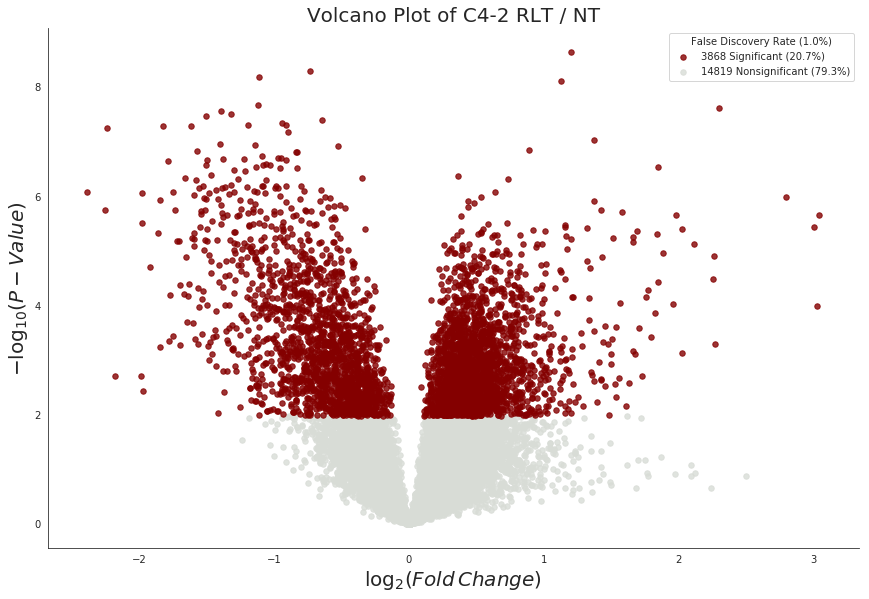

In [23]:
volcano_plot(phospho_t_test.df, phospho_dataset, "Phosphoproteomics_Output/" + volcano_plot_png, fdr_value)

# PCA Plot

PCA plot shows clusters of samples based on their similarity. PCA does not discard any samples or characteristics (variables). Instead, it reduces the overwhelming number of dimensions by constructing principal components (PCs). PCs describe variation and account for the varied influences of the original characteristics. Such influences, or loadings, can be traced back from the PCA plot to find out what produces the differences among clusters.

we perform PCA analysis using untreated and perturbation column names, phospho dataframe and number of principal components that you want. 

In [24]:
from uclacode.utils import pca_analysis
from uclacode.utils import pca_plot

In [25]:
untreated_list = ['Protein Normalized Abundances (Scaled): F1: 126, Control, NT, 18632',
                           'Protein Normalized Abundances (Scaled): F1: 127N, Sample, NT, 18633',
                           'Protein Normalized Abundances (Scaled): F1: 127C, Sample, NT, 18636',
                           'Protein Normalized Abundances (Scaled): F1: 128N, Sample, NT, 18639',
                           'Protein Normalized Abundances (Scaled): F1: 128C, Sample, NT, 18640']

perturbation_list = ['Protein Normalized Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
                             'Protein Normalized Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
                             'Protein Normalized Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
                             'Protein Normalized Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
                             'Protein Normalized Abundances (Scaled): F1: 131, Sample, RLT, 18575']

phospho_columns = untreated_list + perturbation_list
pca, pca_df = pca_analysis(phospho.df, phospho_columns, 2)

[('PC-1', 0.39262062887772664), ('PC-2', 0.2521361131929044)]


In [26]:
pca_df.head()

PC-1      PC-2  \
Protein Normalized Abundances (Scaled): F1: 126... -0.272665 -0.178332   
Protein Normalized Abundances (Scaled): F1: 127... -0.337443 -0.096990   
Protein Normalized Abundances (Scaled): F1: 127... -0.141011 -0.262470   
Protein Normalized Abundances (Scaled): F1: 128... -0.320603 -0.145945   
Protein Normalized Abundances (Scaled): F1: 128... -0.234007 -0.153060   

                                                                     Labels  
Protein Normalized Abundances (Scaled): F1: 126...  126, Control, NT, 18632  
Protein Normalized Abundances (Scaled): F1: 127...  127N, Sample, NT, 18633  
Protein Normalized Abundances (Scaled): F1: 127...  127C, Sample, NT, 18636  
Protein Normalized Abundances (Scaled): F1: 128...  128N, Sample, NT, 18639  
Protein Normalized Abundances (Scaled): F1: 128...  128C, Sample, NT, 18640

In [27]:
# the following functions are used to plot the PCA results 

def label_point(x, y, val, ax):
    """
    :param x:
    :param y:
    :param val:
    :param ax:
    :return:
    """
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-0.01, point['y']+0.02, str(point['val']))


def pca_plot(pca_output, pca_output_filepath, variance_ratio):
    fig, ax = plt.subplots(figsize=(16, 9))
    ax = sns.regplot(x=pca_output.columns[0], y=pca_output.columns[1],
                     data=pca_output, ci=None, fit_reg=False, scatter_kws={"s": 100})
    plt.title('PCA Plot (Protein Normalized Phosphopeptides)', fontsize=20)
    # Set x-axis label
    plt.xlabel('PC-1: {}%'.format(str(round(variance_ratio[0] * 100, 2))), fontsize=20)
    # Set y-axis label
    plt.ylabel('PC-2: {}%'.format(str(round(variance_ratio[1] * 100, 2))), fontsize=20)
    label_point(pca_output['PC-1'], pca_output['PC-2'], pca_output['Labels'], plt.gca())
    plt.savefig(pca_output_filepath)
    plt.show()

PCA Plot File: Phosphoproteomics_Output/jc_QE_122218_C4-2_Actinium_48h_Phos-_PeptideGroups_Protein_Normalized_pca_plot.png


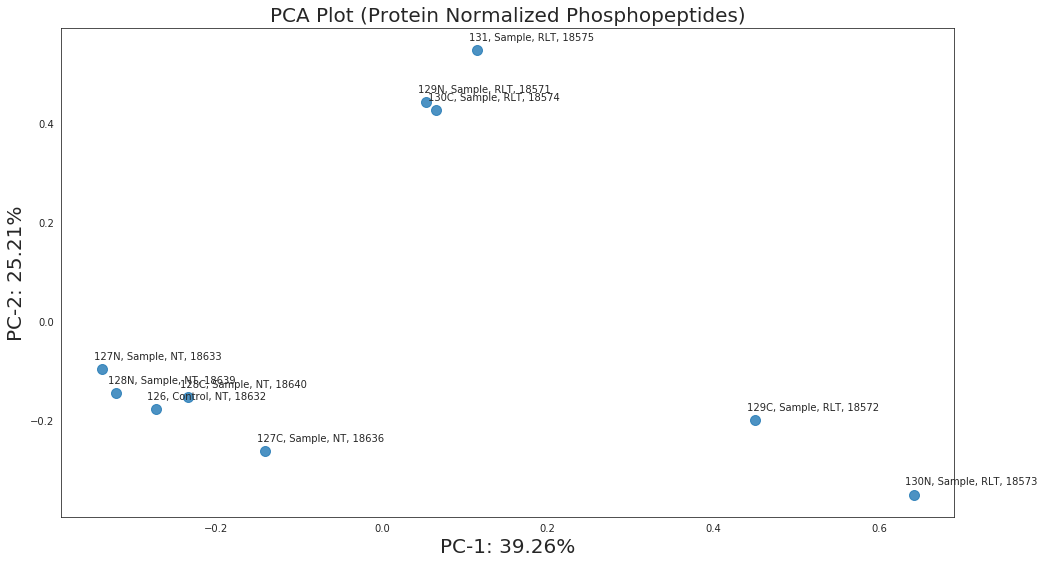

In [28]:
pca_plot_png = 'Phosphoproteomics_Output/' + phospho_dataset.replace('.csv', '') + "_Protein_Normalized_pca_plot.png"
print("PCA Plot File: {}".format(pca_plot_png))
pca_plot(pca_df, pca_plot_png, pca.explained_variance_ratio_)

# Gene Subsetting 

For this step we require wikipathways csv file currently we have wikipathways file for human and mouse. the code reads wikipathways.csv file into pathway_genes dataframe. next we are checking for all columns of pathway_genes df with phospho_df dataframe if they have matching column values then True else false. 
at last we are writing the results to a same csv file in which we saved t_test results.

In [29]:
import pandas as pd
import numpy as np
from collections import Counter
import ast
from uclacode.utils import pathway_genes_checker

In [30]:
phospho_output = phospho.df

In [31]:
pathway_genes = pd.read_csv('Human_WikiPathways.csv')
print(pathway_genes.columns)

for col in pathway_genes.columns:
    col_results=pathway_genes_checker(phospho_output, 'Gene Name', list(pathway_genes[col].dropna().values))
    print(col, Counter(col_results))
    phospho_output[col] = col_results
    
phospho_output.to_csv(t_test_output, index=False)

Index(['name', 'version', 'wpid', 'org', 'gene', 'Gene_Symbols', 'Gene_Names'], dtype='object')
name Counter({False: 18687})
version Counter({False: 18687})
wpid Counter({False: 18687})
org Counter({False: 18687})
gene Counter({False: 18687})
Gene_Symbols Counter({True: 9866, False: 8821})
Gene_Names Counter({False: 18686, True: 1})


# Extract Clusters from Python Dendrogram

Hierarchical clustering is where you build a cluster tree (a dendrogram) to represent data, where each group (or “node”) links to two or more successor groups. The groups are nested and organized as a tree, which ideally ends up as a meaningful classification scheme.Each node in the cluster tree contains a group of similar data; Nodes group on the graph next to other, similar nodes. Clusters at one level join with clusters in the next level up, using a degree of similarity; The process carries on until all nodes are in the tree, which gives a visual snapshot of the data contained in the whole set. The total number of clusters is not predetermined before you start the tree creation.

In [32]:
import pandas as pd
import os
import numpy as np

from collections import defaultdict

import pandas as pd
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
from fastcluster import linkage
import seaborn as sns
from matplotlib.colors import rgb2hex, colorConverter

In [33]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html
    
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

sns.set_palette('Set1', 10, 0.65)
palette = sns.color_palette(sns.color_palette("Spectral_r", 20))
set_link_color_palette(list(map(rgb2hex, palette)))
sns.set_style('white')

def description_count(column):
    cluster_keys = [gene_cluster[g] for g in gene_list]
    cluster_description_dict = {}
    for i, key in enumerate(cluster_keys):
        bp = cluster_description[cluster_description['Gene Cluster'] == key][column].values
        print('\n', gene_list[i], ': ')
        des_counter = Counter([j for sublist in [str(i).split(';') for i in bp] for j in sublist if 'nan' not in j]).most_common()
        for c in des_counter:
            print(c)

In [34]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [35]:
phospho_output = phospho.df
X = phospho_output[['Protein Normalized Abundances (Scaled): F1: 126, Control, NT, 18632',
                           'Protein Normalized Abundances (Scaled): F1: 127N, Sample, NT, 18633',
                           'Protein Normalized Abundances (Scaled): F1: 127C, Sample, NT, 18636',
                           'Protein Normalized Abundances (Scaled): F1: 128N, Sample, NT, 18639',
                           'Protein Normalized Abundances (Scaled): F1: 128C, Sample, NT, 18640',
                    'Protein Normalized Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
                             'Protein Normalized Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
                             'Protein Normalized Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
                             'Protein Normalized Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
                             'Protein Normalized Abundances (Scaled): F1: 131, Sample, RLT, 18575']][phospho_output['RLT FDR']==1].dropna()

In [36]:
X = X.values

#### Silhouette analysis
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]. Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
For detailed explanation refer - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.5386284737103407


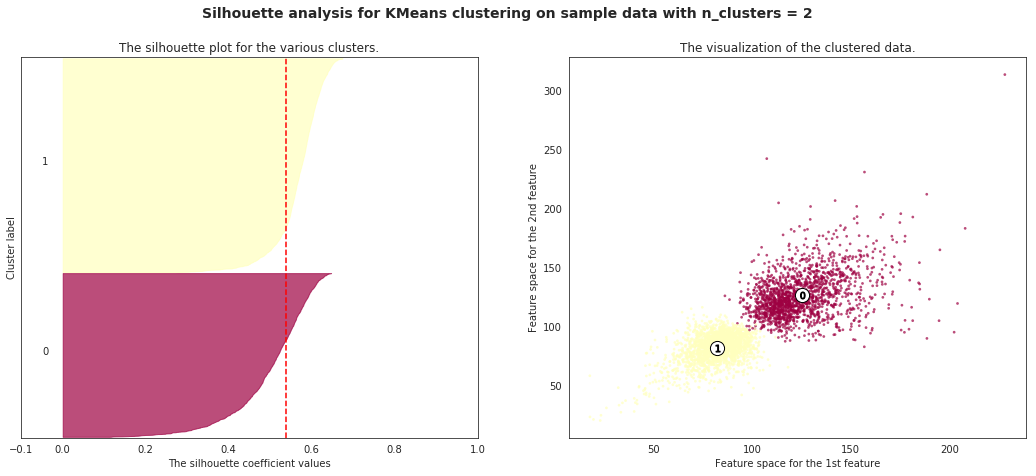

For n_clusters = 3 The average silhouette_score is : 0.458233361810894


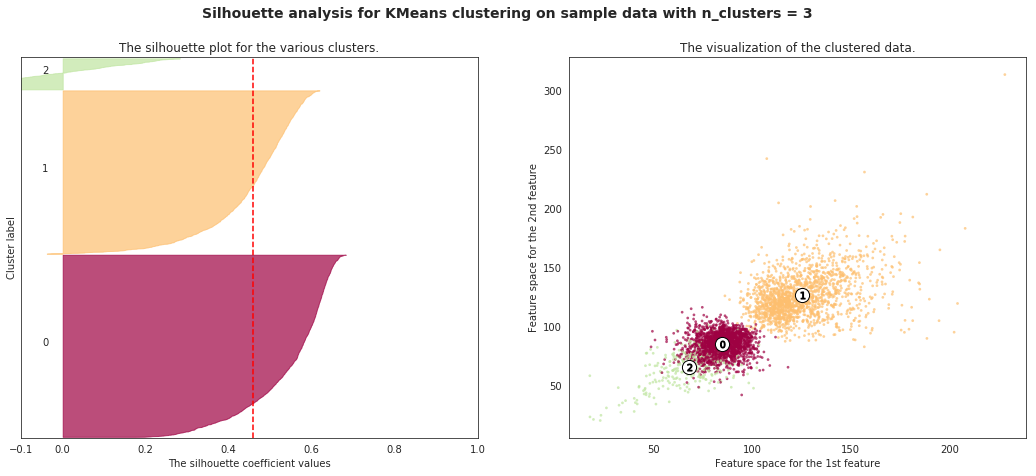

For n_clusters = 4 The average silhouette_score is : 0.3871183412206618


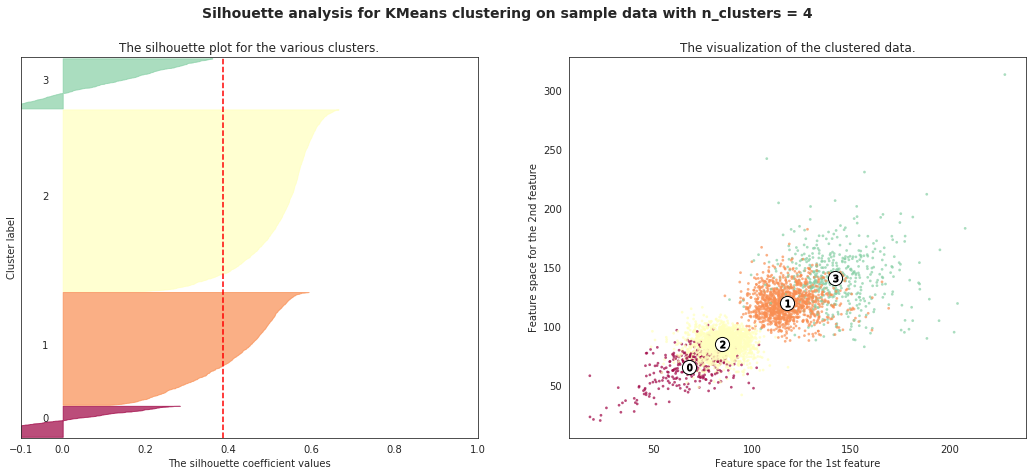

For n_clusters = 5 The average silhouette_score is : 0.3397000528744486


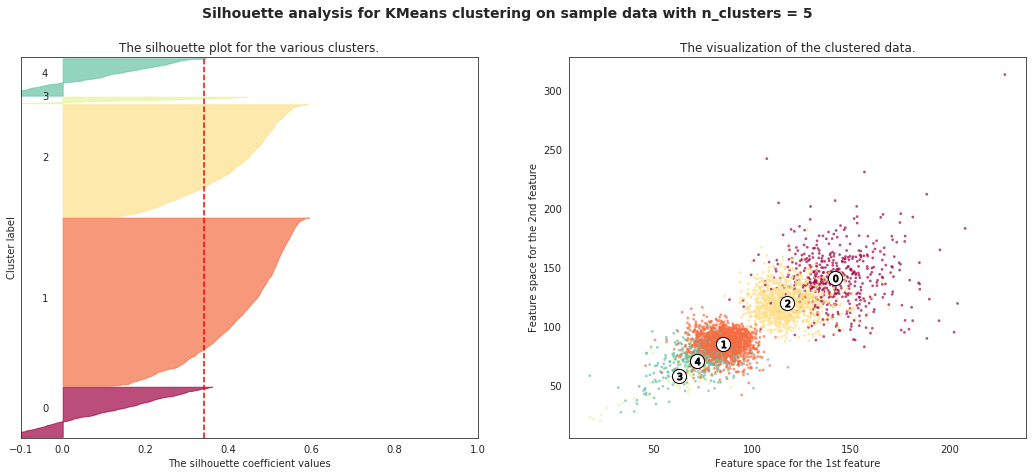

For n_clusters = 6 The average silhouette_score is : 0.2900932712415179


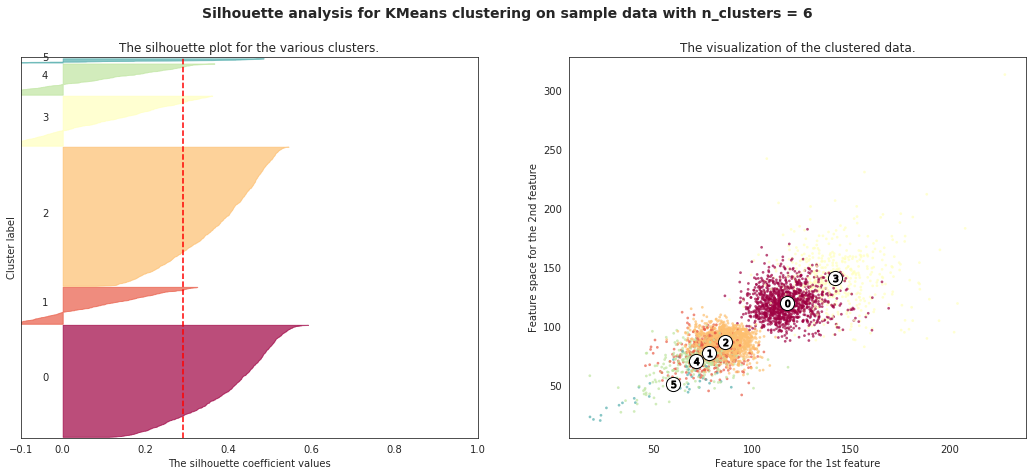

In [37]:
range_n_clusters = np.arange(2, 7)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig("Phosphoproteomics_Output/silhouette_analysis_k_means_{}.png".format(n_clusters))
    plt.show()

In [38]:
range_n_clusters = np.arange(2, 10)
nrefs = 10
inertia=[]
silhouette_avgs = []
best_n_clusters = 0
best_silhouette_avg = np.inf
best_n_clusters_list = []
best_silhouette_avg_list = []
gaps=[]
s_ks=[]
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    refDisps = np.zeros(nrefs)
    
    # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
    for i in range(nrefs):

        # Create new random reference set
        randomReference = np.random.random_sample(size=X.shape)

        # Fit to it
        km = KMeans(n_clusters)
        km.fit(randomReference)

        refDisp = km.inertia_
        refDisps[i] = refDisp
    sd_k = np.std(np.log(refDisps))
    s_k = np.sqrt(1+1/len(refDisps))*sd_k
    s_ks.append(s_k)
        
    # Calculate gap statistic
    gap = np.mean(np.log(refDisps)) - np.log(clusterer.inertia_)

    print("For n_clusters: {}".format(n_clusters)),
    print("The average silhouette_score is :{}".format(silhouette_avg))
    print("Within-Cluster Sum of Squared value: {}".format(clusterer.inertia_))
    print("Gap Statistic: {}".format(gap))
    inertia.append(clusterer.inertia_)
    silhouette_avgs.append(silhouette_avg)
    gaps.append(gap)
    
    if best_silhouette_avg > silhouette_avg:
        best_n_clusters = n_clusters
        best_silhouette_avg = silhouette_avg
    else:
        best_n_clusters_list.append(n_clusters-1)
        best_silhouette_avg_list.append(silhouette_avgs[-2])

For n_clusters: 2
The average silhouette_score is :0.5386284737103407
Within-Cluster Sum of Squared value: 10850954.214180468
Gap Statistic: -8.201369775231772
For n_clusters: 3
The average silhouette_score is :0.458233361810894
Within-Cluster Sum of Squared value: 9300676.375901561
Gap Statistic: -8.102215976245198
For n_clusters: 4
The average silhouette_score is :0.3871183412206618
Within-Cluster Sum of Squared value: 7822529.009554789
Gap Statistic: -7.972498939256878
For n_clusters: 5
The average silhouette_score is :0.3397000528744486
Within-Cluster Sum of Squared value: 7078449.249105099
Gap Statistic: -7.906247161827348
For n_clusters: 6
The average silhouette_score is :0.2900932712415179
Within-Cluster Sum of Squared value: 6599901.315451935
Gap Statistic: -7.871635916134067
For n_clusters: 7
The average silhouette_score is :0.23573690830668229
Within-Cluster Sum of Squared value: 6221715.573832822
Gap Statistic: -7.840877701107976
For n_clusters: 8
The average silhouette_scor

In [39]:
gaps

[-8.201369775231772,
 -8.102215976245198,
 -7.972498939256878,
 -7.906247161827348,
 -7.871635916134067,
 -7.840877701107976,
 -7.819321264952977,
 -7.790529251916718]

In [40]:
gap_stats = np.array(gaps)[:-1] - (np.array(gaps) - np.array(s_ks))[1:]
gap_stats

array([-0.09358409, -0.12552837, -0.06250174, -0.030135  , -0.02727674,
       -0.01613406, -0.02530045])

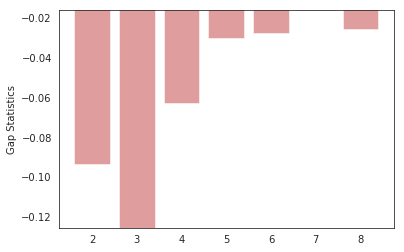

In [41]:
plt.bar(np.arange(2,len(gap_stats)+2), gap_stats, align='center', alpha=0.5)
plt.ylabel('Gap Statistics') 
plt.xticks(np.arange(2,len(gap_stats)+2))
plt.ylim(min(gap_stats), max(gap_stats)) 
plt.show()

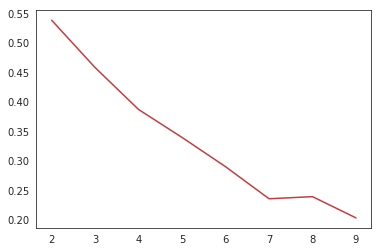

In [42]:
plt.plot(range_n_clusters, silhouette_avgs)
plt.xticks(range_n_clusters)
plt.show()

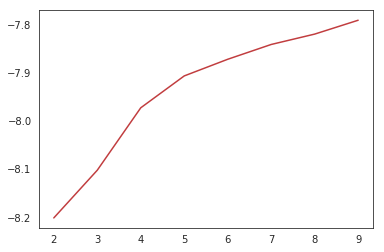

In [43]:
plt.plot(range_n_clusters, gaps)
plt.xticks(range_n_clusters)
plt.show()

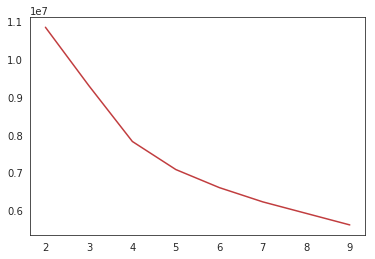

In [44]:
plt.plot(range_n_clusters, inertia)
plt.xticks(range_n_clusters)
plt.show()

In [49]:
clustering_df = phospho_output[['Gene Name', 'Protein Normalized Abundances (Scaled): F1: 126, Control, NT, 18632',
                           'Protein Normalized Abundances (Scaled): F1: 127N, Sample, NT, 18633',
                           'Protein Normalized Abundances (Scaled): F1: 127C, Sample, NT, 18636',
                           'Protein Normalized Abundances (Scaled): F1: 128N, Sample, NT, 18639',
                           'Protein Normalized Abundances (Scaled): F1: 128C, Sample, NT, 18640',
                    'Protein Normalized Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
                             'Protein Normalized Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
                             'Protein Normalized Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
                             'Protein Normalized Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
                             'Protein Normalized Abundances (Scaled): F1: 131, Sample, RLT, 18575']][phospho_output['RLT FDR'] == 1].dropna()

In [50]:
clustering_df.shape

(3868, 11)

In [51]:
genes = clustering_df.pop('Gene Name').astype('str')
genes = pd.Series([i + ' ' + j for i, j in list(zip(genes, genes.index.astype('str')))], index=genes.index)
clustering_df.index = genes
clustering_df.columns = ["NT {}".format(i) for i in range(1,6)] + ["RLT {}".format(i) for i in range(1,6)]

In [52]:
# linkage function belongs to library fastcluster it performs Hierarchical, agglomerative clustering on a condensed dissimilarity matrix or on vector data. it takes 
#input dataframe, method of clustering and metric used to compute results for clustering. 

row_link = linkage(clustering_df, method='complete',  metric='euclidean')
col_link = linkage(clustering_df.T, method='average',  metric='euclidean')

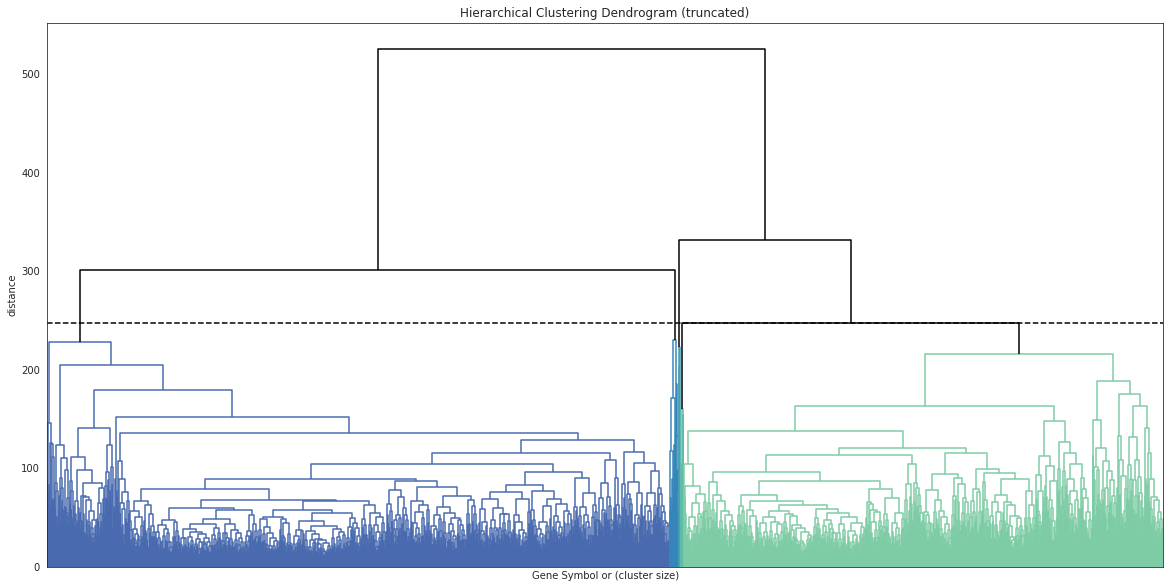

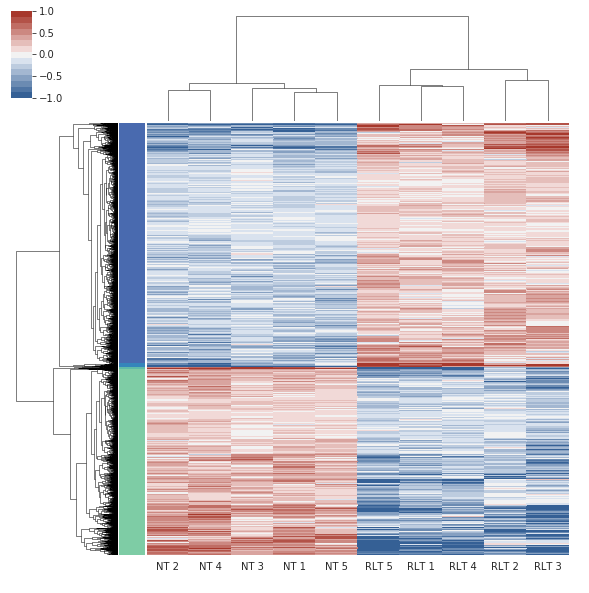

In [53]:
optimum_clusters = 5
complete_den = dendrogram(Z=row_link, labels=clustering_df.index,no_plot=True, leaf_font_size=8,
                          above_threshold_color='k')
max_d = int(np.max(complete_den['dcoord']))
while len(set(complete_den['color_list'])) < (optimum_clusters+1):
        max_d-=1
        complete_den = dendrogram(Z=row_link, labels=clustering_df.index, 
                          color_threshold=max_d, no_plot=True, leaf_font_size=8,
                          above_threshold_color='k')
                        
fig, ax = plt.subplots(figsize=(20, 10))
complete_den = dendrogram(Z=row_link, labels=clustering_df.index, 
                          color_threshold=max_d, no_plot=False, leaf_font_size=8,
                          above_threshold_color='k', no_labels=True)

color_dict = {}
for key, values in get_cluster_classes(complete_den).items():
    for value in values:
        color_dict[value] = key
                
color_series = pd.Series(genes.map(color_dict))
color_series.index = genes

plt.xticks(rotation=90)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Gene Symbol or (cluster size)')
plt.ylabel('distance')
plt.axhline(y=max_d, c='k', linestyle='--')
plt.savefig('Phosphoproteomics_Output/dendrogram.png')

row_colors = color_series
row_colors.index.name = ' '
cmap_input = sns.diverging_palette(250, 15, s=75, l=40, n=15, center="light")
clustering_df = clustering_df.astype(float)
clustermap_input = np.log2(clustering_df/100)

g = sns.clustermap(clustermap_input, row_linkage=row_link, col_linkage=col_link,cmap=cmap_input, vmin = -1.0, vmax=1.0, 
                   cbar_kws={"ticks":np.linspace(-1.0, 1.0, num=5)}, row_colors=row_colors, 
                   figsize=(10, 10), linewidth=0, yticklabels=False)
ax = g.ax_heatmap
ax.set(xlabel=' ', ylabel=' ')
g.savefig("Phosphoproteomics_Output/clustermap.png")

In [54]:
get_cluster_classes(complete_den)
color_gene_dict = get_cluster_classes(complete_den)
color_gene_dict = {i:values for i, values in enumerate(color_gene_dict.values())}

In [55]:
get_cluster_classes(complete_den)
gene_cluster = get_cluster_classes(complete_den)
gene_cluster_df = pd.DataFrame([(i+1, value) for i, value in enumerate(gene_cluster.values()) if value is not None], columns=['Cluster', 'Genes'])

In [56]:
max_genes = max([len(i) for i in gene_cluster_df['Genes']])
gene_cluster_final = [] 
for i in range(len(gene_cluster_df['Genes'])):
    gene_cluster_final.append(gene_cluster_df['Genes'][i] + [None]*(max_genes - len(gene_cluster_df['Genes'][i])))
    
gene_cluster_final = pd.DataFrame(gene_cluster_final, index=np.arange(1,len(gene_cluster_final)+1))
gene_cluster_final.T.head(2)

1                                            2  \
0         ['NBN', 'NBN'] 9673                ['HSP90AB1', 'HSP90AB2P'] 325   
1  ['NBN', 'NBN', 'NBN'] 5020  ['HSP90AB1', 'HSP90AB2P', 'HSP90AB3P'] 1858   

                                                   3  \
0  ['EIF4G1', 'EIF4G1', 'EIF4G1', 'EIF4G1', 'EIF4...   
1  ['EIF4G1', 'EIF4G1', 'EIF4G1', 'EIF4G1', 'EIF4...   

                                                   4  \
0  ['ILF3', 'ILF3', 'ILF3', 'ILF3', 'ILF3', 'ILF3...   
1                             ['ILF3', 'ILF3'] 17387   

                           5  
0  ['INPP5F', 'INPP5F'] 7479  
1  ['INPP5F', 'INPP5F'] 7454

In [57]:
gene_cluster_final.T.to_csv('Phosphoproteomics_Output/gene_cluster_df.csv', index=False)

In [58]:
gene_number = {}
for key, values in color_gene_dict.items():
    for value in values:
        gene_number[value] = key+1
        
gene_indexes = [str(i) + ' ' + str(j) for i, j in list(zip(phospho_output['Gene Name'], phospho_output.index))]
clusters=[]
for g in gene_indexes:
    try:
        clusters.append(gene_number[g])
    except KeyError:
        clusters.append(None)
        
phospho_output['Cluster'] = list(map(lambda x: None if x is None else int(x), clusters))
phospho_output.to_csv(t_test_output, index = False)

### Sync results from workspace to polly

In [ ]:
syncresults = "polly files sync --workspace-id %(workspace_id)s -s /import/uclacode/Phosphoproteomics_Output/ -d polly://Phosphoproteomics_Results/"%locals()
sb.call(syncresults, shell = True)

# KSEA

In [45]:
phospho_output.columns

Index(['Protein Accessions', 'Modifications (all possible sites)',
       'Protein Accession Ranges', 'Sequence', 'Protein Name',
       'Protein Entry Name', 'Gene Name', 'Phospho Site',
       'Phospho Annotations', 'Phospho Centralised Sequence',
       'Abundances (Scaled): F1: 126, Control, NT, 18632',
       'Abundances (Scaled): F1: 127N, Sample, NT, 18633',
       'Abundances (Scaled): F1: 127C, Sample, NT, 18636',
       'Abundances (Scaled): F1: 128N, Sample, NT, 18639',
       'Abundances (Scaled): F1: 128C, Sample, NT, 18640',
       'Abundances (Scaled): F1: 129N, Sample, RLT, 18571',
       'Abundances (Scaled): F1: 129C, Sample, RLT, 18572',
       'Abundances (Scaled): F1: 130N, Sample, RLT, 18573',
       'Abundances (Scaled): F1: 130C, Sample, RLT, 18574',
       'Abundances (Scaled): F1: 131, Sample, RLT, 18575', 'Untreated Mean',
       'Perturbation Mean', 'Phosphoproteomics Fold Change',
       'Proteomics Fold Change', 'Average Proteomics Fold Change',
       'No

In [46]:
phospho_subset = phospho_output[['Protein Accessions', 'Gene Name', 'Sequence', 'Phospho Site', 'RLT P-value', 'RLT Fold Change', 'RLT FDR', 'Cluster']]

In [47]:
phospho_subset.head(20)

Protein Accessions  \
13584                                           [Q13185]   
8996                                            [Q9BPX5]   
3481                        [P26358-3, P26358, P26358-2]   
21019  [O96017-9, O96017-11, O96017-12, O96017-4, O96...   
20009                 [I3L1L3, Q9BQG0, Q9BQG0-2, I3L2H8]   
3419                                  [Q5UIP0-2, Q5UIP0]   
2402            [F5H479, H0YFI1, Q6IAA8, F5H3Y3, F5GX19]   
1709                        [Q92890-1, Q92890, Q92890-3]   
9406                [O75367-3, O75367-2, D6RCF2, O75367]   
12482       [B9EGQ5, O95785-4, O95785, M0QXA7, O95785-3]   
6001                        [Q13045, Q13045-3, Q13045-2]   
5434   [P35658, P35658-4, A0A0A0MSW3, P35658-5, P3565...   
8185                            [Q9P2W9, D6RC71, D6RF48]   
5922            [A0A0A0MRM9, Q14978, Q14978-2, Q14978-3]   
19136                                   [P20700, Q03252]   
15225  [Q13428-5, Q13428-3, Q13428-4, Q13428-7, E7ETY...   
11837             [P78347-3, P78347-4, P78347, P78347-2]   
6174                                            [O75459]   
2511                [A9IYQ1, Q9NTI5-5, Q9NTI5-2, Q9NTI5]   
15212             [Q96S66, Q96S66-3, Q96S66-2, Q96S66-4]   

                                               Gene Name  \
13584                                             [CBX3]   
8996                                            [ARPC5L]   
3481                               [DNMT1, DNMT1, DNMT1]   
21019         [CHEK2, CHEK2, CHEK2, CHEK2, CHEK2, CHEK2]   
20009               [MYBBP1A, MYBBP1A, MYBBP1A, MYBBP1A]   
3419                                        [RIF1, RIF1]   
2402       [LAMTOR1, LAMTOR1, LAMTOR1, LAMTOR1, LAMTOR1]   
1709                                  [UFD1, UFD1, UFD1]   
9406        [MACROH2A1, MACROH2A1, MACROH2A1, MACROH2A1]   
12482                          [WIZ, WIZ, WIZ, WIZ, WIZ]   
6001                                  [FLII, FLII, FLII]   
5434    [NUP214, NUP214, NUP214, NUP214, NUP214, NUP214]   
8185                               [STX18, STX18, STX18]   
5922                        [NOLC1, NOLC1, NOLC1, NOLC1]   
19136                                     [LMNB1, LMNB2]   
15225  [TCOF1, TCOF1, TCOF1, TCOF1, TCOF1, None, TCOF...   
11837                       [GTF2I, GTF2I, GTF2I, GTF2I]   
6174                                             [PAGE1]   
2511                        [PDS5B, PDS5B, PDS5B, PDS5B]   
15212                       [CLCC1, CLCC1, CLCC1, CLCC1]   

                        Sequence  \
13584               LTWHSCPEDEAQ   
8996              AFHAALRNSPVNTK   
3481             SFEDPPNHARSPGNK   
21019              TQVSLKDQITSGK   
20009              GVLGKSPLSALAR   
3419         SEVVESTTESQDKENSHQK   
2402                KLLLDPSSPPTK   
1709            GVEPSPSPIKPGDIKR   
9406               GKLEAIITPPPAK   
12482               TPLALAGSPTPK   
6001              NAEAVLQSPGLSGK   
5434           SPRITPPAAKPGSPQAK   
8185       VSQSPSKDSEENPATEERPEK   
5922      NSSNKPAVTTKSPAVKPAAAPK   
19136                 LKLSPSPSSR   
15225              TVANLLSGKSPRK   
11837               TNTPVKEDWNVR   
6174   NEEQMKLPAEGPEPEADSQEQVHPK   
2511            KKSGPPAPEEEEEEER   
15212               FQTGNKSPEVLR   

                                            Phospho Site   RLT P-value  \
13584                       [[S352, S355], [S352, S355]]  2.313779e-09   
8996   [[S353], [S382], [S348], [S329], [S378], [S381...  5.024082e-09   
3481   [[S604], [S376], [S603], [S370], [S380], [S370...  6.684731e-09   
21019  [[S1556], [S1556], [S1556], [S1556], [S1556], ...  7.753582e-09   
20009                                           [[T115]]  2.166932e-08   
3419                                    [[T438], [T438]]  2.446667e-08   
2402         [[S34], [S122], [S32], [S34], [S34], [S34]]  2.703700e-08   
1709   [[S83], [S280], [S1410], [S863], [S1358], [S13...  3.101825e-08   
9406                              [[S157], [S18], [S18]]  3.364601e-08   
12482              

In [48]:
phospho_subset.shape

(18687, 8)

In [49]:
# phospho_subset.loc[21019,][['Protein Accessions','Phospho Site']]

In [54]:
def expand_accession_df(df, gene_column, site_column, accession_column):
    columns = df.columns
    new_df_subset = []
    accession_values = df[accession_column].values
    gene_values = df[gene_column].values
    site_values = df[site_column].values
    df_subset_drop = df.drop([accession_column, gene_column, site_column], axis=1).values
    for i, i_list in enumerate(accession_values):
        for j, i_value in enumerate(i_list):
            sub_list = []
            sub_list.append(i_value)
            sub_list.append(gene_values[i][j])
            sub_list.append(site_values[i][j])
            sub_list = sub_list + df_subset_drop[i].tolist()
            new_df_subset.append(sub_list)
#         print(new_df_subset)
    return pd.DataFrame(new_df_subset, columns=columns)

In [55]:
new_df_subset = expand_accession_df(phospho_subset,'Gene Name','Phospho Site', 'Protein Accessions')

# new_df_subset.columns = [
#     'Protein', 'Residue.Both', 'Gene', 'Peptide',
#        'p', 'FC', 'FDR', 'Cluster'
# ]

# new_df_subset = new_df_subset[[
#     'Protein', 'Gene', 'Peptide', 'Residue.Both',
#        'p', 'FC', 'FDR', 'Cluster'
# ]]

# new_df_subset['Residue.Both'] = [";".join(i) for i in new_df_subset['Residue.Both']]
# new_df_subset = new_df_subset.dropna()
# new_df_subset = new_df_subset[new_df_subset['FDR'] == 1]
# new_df_subset = new_df_subset.drop('FDR', axis=1)
# new_df_subset.to_csv('Phosphoproteomics_Output/Actinium_ksea_input.csv', index=False)
# new_df_subset.head()

IndexError: list index out of range

In [12]:
# NORMALIZATION CODE FIX

# def normalize_data_ours(df,
#                         proteomics_df,
#                         mydict,
#                         proteomics_accesion_id_dict,
#                         proteomics_fold_change_dict,
#                         phospho_untreated_list,
#                         phospho_perturbation_list):
    
#     abundances_scaled = phospho_untreated_list + phospho_perturbation_list
#     for column in abundances_scaled:
#         mydict[column] = []
#         abundances_scaled_list = df[column].tolist()
#         for i in range(df.shape[0]):
#             mydict[column].append(abundances_scaled_list[i])
    
#     dataframe = pd.DataFrame.from_dict(mydict,orient='index')
#     dataframe = dataframe.transpose()
    
#     dataframe['Untreated Mean'] = dataframe[phospho_untreated_list].mean(axis=1)
#     dataframe['Perturbation Mean'] = dataframe[phospho_perturbation_list].mean(axis=1)
#     dataframe['Phosphoproteomics Fold Change'] = dataframe['Perturbation Mean'] / dataframe['Untreated Mean']

#     proteomics_df['Untreated Mean'] = proteomics_df[proteomics_untreated_list].mean(axis=1)
#     proteomics_df['Perturbation Mean'] = proteomics_df[proteomics_perturbation_list].mean(axis=1)
#     proteomics_df['Proteomics Fold Change'] = proteomics_df['Perturbation Mean'] / proteomics_df['Untreated Mean']
    
#     for col in abundances_scaled:
#         proteomics_df['Proteomics ' + col] = proteomics_df[col]

#         dataframe['Proteomics Fold Change'] = fold_change(dataframe, 'Protein Accessions',
#                                                         proteomics_accesion_id_dict,
#                                                         proteomics_fold_change_dict)

#         dataframe['Average Proteomics Fold Change'] = average_fold_change(dataframe)

#         dataframe['Normalized Fold Change'] = dataframe['Phosphoproteomics Fold Change'] / dataframe['Average Proteomics Fold Change']

#         proteomics_abundances_scaled = ['Proteomics ' + col for col in abundances_scaled]
#         dataframe = append_proteomics(dataframe, proteomics_df, proteomics_accession_id,
#                                     proteomics_accesion_id_dict, proteomics_abundances_scaled)

#         for col in abundances_scaled:
#             dataframe['Protein Normalized {}'.format(col)] = (100 / dataframe[
#                 'Average Proteomics {}'.format(col)]) * \
#                                                            dataframe[col]

#         norm_abundances_scaled = ['Protein Normalized {}'.format(col) for col in abundances_scaled]

#         dataframe['Protein Normalized'] = dataframe[norm_abundances_scaled].notnull().all(axis=1)

#     return self

# dataframe = normalize_data_ours(phospho.df, 
#                                 phospho.proteomics_df,
#                                 phospho.dict,
#                                 phospho.proteomics_accesion_id_dict ,
#                                 phospho.proteomics_fold_change_dict,
#                                 phospho_untreated_list,
#                                 phospho_perturbation_list)

# dataframe.head()

# working code of fold change

# def fold_change(df, accession_string, proteomics_accesion_id_dict, proteomics_fold_change_dict):
#     proteomics_fc = []
#     for acc_list in df[accession_string]:
#         fc_list = []
#         if acc_list is not None:
#             for acc in acc_list:
#                 try:
#                     acc_id = proteomics_accesion_id_dict[acc]
#                     fc = proteomics_fold_change_dict[acc_id]
#                     fc_list.append(fc)
#                 except KeyError:
#                     fc_list.append(None)
#         else:
#             fc_list.append(None)
#         proteomics_fc.append(fc_list)
#     return proteomics_fc

# proteomics_fc = fold_change(dataframe, 'Protein Accessions',phospho.proteomics_accesion_id_dict,phospho.proteomics_fold_change_dict)

# My modifications for process_data function 

In [15]:
from uclacode.utils import *

In [16]:
def add_doug_annotations(motif_dict, mods_dict, sig_mods_dict_modified):
    mod_names = [mod for mod in sig_mods_dict_modified.keys() if mod.find('_variables_positions') is not -1]
    mod_names = [mod.replace('_variables_positions', '') for mod in mod_names]
    mod_names = [mod.replace('significant_', '') for mod in mod_names]
    accessions = motif_dict['Protein Accessions']
    for mod_name in mod_names:
        mod_values = mods_dict['{}_value'.format(mod_name)]
        sig_mods = sig_mods_dict_modified['significant_{}_variables'.format(mod_name)]
        motif_dict[mod_name + ' Annotations'] = doug_annotations(mod_name, accessions, mod_values, sig_mods)
    return motif_dict, mod_names

In [17]:
# mydict = dict()
# mydict['Protein Accessions'] = list()
# mydict['Modifications (all possible sites)'] = list()
# mydict['Protein Accession Ranges'] = list()
# mydict['Sequence'] = list()

# mods_dict = dict()
sig_mods_dict = dict()
lhs_range = list()
sig_mods_dict_modified = dict()

In [22]:
def doug_annotations(mod_name, accessions, mod_values, sig_mods):
    doug_values = []
    for i, mod_list in enumerate(sig_mods):
        if all(mod is None for mod in mod_list):
            doug_values.append([None])
#             print(doug_values)
        else:
            doug_sub_values = []
            for j, mod_sublist in enumerate(mod_list):
                if not mod_sublist is None:
#                     print(mod_sublist)
                    doug_obv = []
                    for mod in mod_sublist:
                        doug_obv.append("{} {}x{} {}".format(accessions[i][j], mod_values[i], mod_name, mod))
                    doug_sub_values.append(doug_obv)
                doug_values.append(doug_sub_values)
    return doug_values

def filter_contaminant(df, column, value):
        if column in df.columns:
            df = df[df[column] == value]
        else:
            print("{} not found in dataset".format(column))
        return df

In [24]:
def int_tester(x):
        try:
            return int(x)
        except ValueError:
            return None

def float_tester(x):
    try:
        return float(x)
    except ValueError:
        return None

def mod_stats(mod,mydict,mods_dict):
    class_1_percentage_found = len([i for i in mydict['{} Annotations'.format(mod)] if i != [None]]) / len(
        mydict['{} Annotations'.format(mod)])
    mod_count = len([i for i in mydict['{} Annotations'.format(mod)] if i != [None]])
    mod_sum = sum([int(i) for i in mods_dict['{}_value'.format(mod)] if i is not None])

    print("Class one {} peptide percentage found: {}".format(mod, class_1_percentage_found))
    print("Class one {} peptide count: {}".format(mod, mod_count))
    print("{} sum: {}".format(mod, mod_sum))

    phospho_variables = [i.replace('[', '').replace(']', '').split('; ') for i in
                         mods_dict['Phospho_variables'] if i != None]

    phospho_percentage = []
    for phospho_vars in phospho_variables:
        for phospho_var in phospho_vars:
            phospho_percentage.append(phospho_var.partition('(')[-1][:-1])

    phospho_perc_df = pd.DataFrame(Counter(phospho_percentage).most_common())
    phospho_perc_df[0] = phospho_perc_df[0].apply(float_tester)
    phospho_perc_df = phospho_perc_df.sort_values(0, ascending=False)
    phospho_perc_df.columns = ['Percentage', 'Count']
    csv_file = '{}_percentage_count.csv'.format(mod)
    phospho_perc_df.to_csv(csv_file, index=False)
    print("{} count saved to: {}".format(mod, csv_file))

## made changes in p_list param - added check for not none and in doug_annotations added check for not none

In [20]:
def process_data(df,contaminant_string, sequence_string, accession_string, modification_string, fasta_files):
    mods_dict = dict()
    mydict = dict()
    sig_mods_dict = dict()
    sig_mods_dict_modified = dict()
    mydict['Protein Accessions'] = list()
    mydict['Modifications (all possible sites)'] = list()
    mydict['Protein Accession Ranges'] = list()
    mydict['Sequence'] = list()

    df = filter_contaminant(df, contaminant_string, False)

    accessions = [i.split('; ') for i in df[accession_string]]
    sequences = df[sequence_string].tolist()
    modifications = df[modification_string].tolist()
    mydict['Protein Accessions'] = accessions
    mydict['Modifications (all possible sites)'] = df[modification_string].tolist()
    mydict['Sequence'] = sequences

    complete_ranges = findall_ranges(accessions, sequences, fasta_files)
    mydict['Protein Accession Ranges'] = complete_ranges

    # Create a list of lists that c ontains the individual modifications that are carried out on each observation.
    motif_mods = [i.split(']; ') for i in mydict[modification_string]]
    motif_mods = [[i + ']' if i.find(']') == -1 else i for i in motif_mods[j]] for j in range(len(motif_mods))]
#     print(list(mydict.items())[:1])
    # Determine the key features that appear in the modifications column.
    unique_mod_types = findall_unique_mod_types(modifications)   
     #Create a dictionary that breaks the modifcations column and creates individual
        # lists for each key feature of the modifications.
    mods_dict = mods_dict_updater(mods_dict, unique_mod_types, motif_mods)
    # Create lists for the LHS and RHS of the range for each entry of the sequence list
    # using the UniProt fasta file.
    lhs_range = findall_uniprot_ranges(mydict)

    all_protein_names, all_entry_names, all_gene_names = findall_uniprot_protein_names(accessions, fasta_files)

    mydict['Protein Name'] = all_protein_names
    mydict['Protein Entry Name'] = all_entry_names
    mydict['Gene Name'] = all_gene_names
    
    sig_mods_dict = sig_mods_dict_updater(mods_dict, sig_mods_dict, unique_mod_types)

        # Create a dictionary that contains individual lists for each key feature
        # of the modifications that is statistically significant.
        # The lists within this dictionary will then eventually be brought together
        # to create the Doug Annotations column.
    sig_mods_dict_modified = sig_mods_dict_modified_updater(sig_mods_dict, sig_mods_dict_modified,
                                                                     lhs_range)
    
#     print(list(sig_mods_dict_modified.items())[1:5])
    sig_var_keys = [key for key in sig_mods_dict_modified.keys() if '_variables_' not in key]
    if len(sig_var_keys) > 0:
            for key in sig_var_keys:
                print("KEY : ",key)
                match = re.search('significant_(.*)_variables', key)
                print("MATCH : ",match)
                column = "{} Site".format(match.group(1))   
                print("COLUMN : ",column)
                col_sig_pos = []
                for positions in sig_mods_dict_modified['significant_Phospho_variables']:
#                     print("POSITIONS : ",positions[0])
                    if positions[0] is None:
                        col_sig_pos.append(None)
                    else:
#                         print(positions[0])
                        col_sig_p = []
                        for p_list in positions:
#                             print(positions)
                            if p_list is not None:
#                                 print(p_list)
                                col_sub_sig_p = []
                                for p in p_list:
                                    col_sub_sig_p.append(re.sub("[\(\[].*?[\)\]]", "", p))
                                col_sig_p.append(col_sub_sig_p)
                            col_sig_pos.append(col_sig_p)
                        
            mydict[column] = col_sig_pos
#             print(list(mydict.items())[:1])
    mydict, mod_names = add_doug_annotations(mydict, mods_dict,
                                                         sig_mods_dict_modified)
    
    for name in mod_names:
        significant_positions = sig_mods_dict_modified['significant_{}_variables_positions'.format(name)]
        print(significant_positions)
        mydict["{} Centralised Sequence".format(name)] = uniprot_centralised_sequence(accessions,
                                                                                             significant_positions,
                                                                                             fasta_files)
        for mod in mod_names:
            mod_stats(mod,mydict,mods_dict)
    return self

In [23]:
phospho = process_data(phospho.df,phospho_contaminant_column, 
               phospho_sequence_column,
               phospho_accession_column,
               phospho_modifications_column,
               fasta_files)

KEY :  significant_Phospho_variables
MATCH :  <_sre.SRE_Match object; span=(0, 29), match='significant_Phospho_variables'>
COLUMN :  Phospho Site
[[None, None], [None, None, None], [[477], [488], [477], [470], [477], [477]], [None], [None], [None, None, None, None], [[467], [478], [467], [460], [467], [467]], [[467], [478], [467], [460], [467], [467]], [[13], [13], [13], [13], [13], [13], [13], [13], [13], [13], [13], [13], [13], [13], [13], [13]], [[413], [96], [96], [440], [428]], [[172]], [[172]], [[593], [424], [393], [605], [140]], [[28], [231]], [[796], [662], [482]], [[912], [912]], [[912], [900], [916]], [[28], [231]], [[494]], [[28], [231]], [[415]], [[2230], [1316]], [[314], [314]], [[136], [1182], [1182]], [[856], [856], [856], [856], [856], [856], [856], [856], [897], [856], [856], [856], [856], [856], [856], [856], [178], [856]], [[240, 244]], [[1815], [1455]], [None, None], [[512]], [[512]], [[625], [412], [314], [625], [137], [150]], [None, None], [[205], [172]], [None, 

Class one Phospho peptide percentage found: 0.9195608506984375
Class one Phospho peptide count: 59971
Phospho sum: 19652
Phospho count saved to: Phospho_percentage_count.csv


NameError: name 'self' is not defined

In [165]:
mod_names

['Phospho']

In [166]:
# mod_names = [mod for mod in sig_mods_dict_modified.keys() if mod.find('_variables_positions') is not -1]
# print(mod_names)
# mod_names = [mod.replace('_variables_positions', '') for mod in mod_names]
# mod_names = [mod.replace('significant_', '') for mod in mod_names]
# print(mod_names)
# accessions = mydict['Protein Accessions']
# for mod_name in mod_names:
#     print(mod_name)
#     mod_values = mods_dict['{}_value'.format(mod_name)]
#     sig_mods = sig_mods_dict_modified['significant_{}_variables'.format(mod_name)]
#     print(sig_mods)
#     mydict[mod_name + ' Annotations'] = doug_annotations(mod_name, accessions, mod_values, sig_mods)

In [168]:
# filename = "mydict.txt"
# filehandler = open(filename, 'wt')
# data = str(mydict)
# filehandler.write(data)

In [167]:
# for mod_name in mod_names:
#     mod_values = mods_dict['{}_value'.format(mod_name)]
#     sig_mods = sig_mods_dict_modified['significant_{}_variables'.format(mod_name)]
#     doug_annotations(mod_name, accessions, mod_values, sig_mods)